In [1]:
SAMPLE_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/sample images/*.dcm'
DATASET_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/dicom-images-train/*/*/*.dcm'
TEST_PATH = 'D:\OneDrive\Desktop\siim-acr-pneumothorax-segmentation\dicom-images-test\*\*.dcm'
RLE_SAMPLE = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv'
RLE_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/train-rle.csv'

In [2]:
import os
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from pydicom.data import get_testdata_files
from glob import glob
from tqdm import tqdm

In [3]:
# def Read_dcm(dataset):
#     print("Filename\t\t\t:", DATASET_PATH)
#     print("Storage\t\t\t\t:", dataset.SOPClassUID)
    
#     name = dataset.PatientName
#     display_name = name.family_name + ", " + name.given_name
    
#     print("Patient's Name\t\t\t:", display_name)
#     print("Patient's ID\t\t\t:", dataset.PatientID)
#     print("Patient's Age\t\t\t:", dataset.PatientAge)
#     print("Patient's Sex\t\t\t:", dataset.PatientSex)
#     print("Modality\t\t\t:", dataset.Modality)
#     print("Body Part Examined\t\t:", dataset.BodyPartExamined)
#     print("View Position\t\t\t:", dataset.ViewPosition)
    
#     if 'PixelData' in dataset:
#         rows = int(dataset.Rows)
#         cols = int(dataset.Columns)
#         print("Image size\t\t\t: {rows:d} x {cols:d}, {size:d} bytes".format(rows=rows, cols=cols, size=len(dataset.PixelData)))
#         if 'PixelSpacing' in dataset:
#             print("Pixel spacing\t\t\t:", dataset.PixelSpacing)
            
#     print('\n')

In [4]:
def PixelArray(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    print(dataset.pixel_array)
    print(plt.cm.bone)
    plt.show()

In [5]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [6]:
# filename = get_testdata_files('rtplan.dcm')[0]
files = sorted(glob(DATASET_PATH))

In [7]:
len(files)

10712

In [13]:
RLEs = pd.read_csv(RLE_PATH)

In [9]:
len(RLEs)

11583

In [10]:
RLEsL = defaultdict(list)

In [14]:
for image_id, rle in zip(RLEs['ImageId'], RLEs[' EncodedPixels']):
    RLEsL[image_id].append(rle)
annotated = {k: v for k, v in RLEsL.items() if v[0] != ' -1'}
print("%d of %d images are annotated (Positive) " % (len(annotated), len(RLEsL)))

2379 of 10675 images are annotated (Positive) 


In [15]:
print('Missing values are: (DROP THESE)', len(files) - len(RLEsL))

Missing values are: (DROP THESE) 37


In [ ]:
# means = []
# for fn in tqdm(files):
#     img = pydicom.read_file(fn).pixel_array
#     means.append(img.mean())

In [ ]:
# print("Test mean: ", np.mean(means))

In [ ]:
# for file_path in glob(SAMPLE_PATH):
#     dataset = pydicom.dcmread(file_path)
#     Read_dcm(dataset)
#     PixelArray(dataset)
#     break

In [16]:
start = 0
numberOfImages = 10

# fig, ax = plt.subplots(nrows = 1, ncols = numberOfImages, sharey=True, figsize=(numberOfImages*10, 10))
# for q, path in enumerate(glob(SAMPLE_PATH)[start:start+numberOfImages]):
#     dataset = pydicom.dcmread(path)
#     ax[q].imshow(dataset.pixel_array, cmap = plt.cm.bone)

KeyError: '1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027'

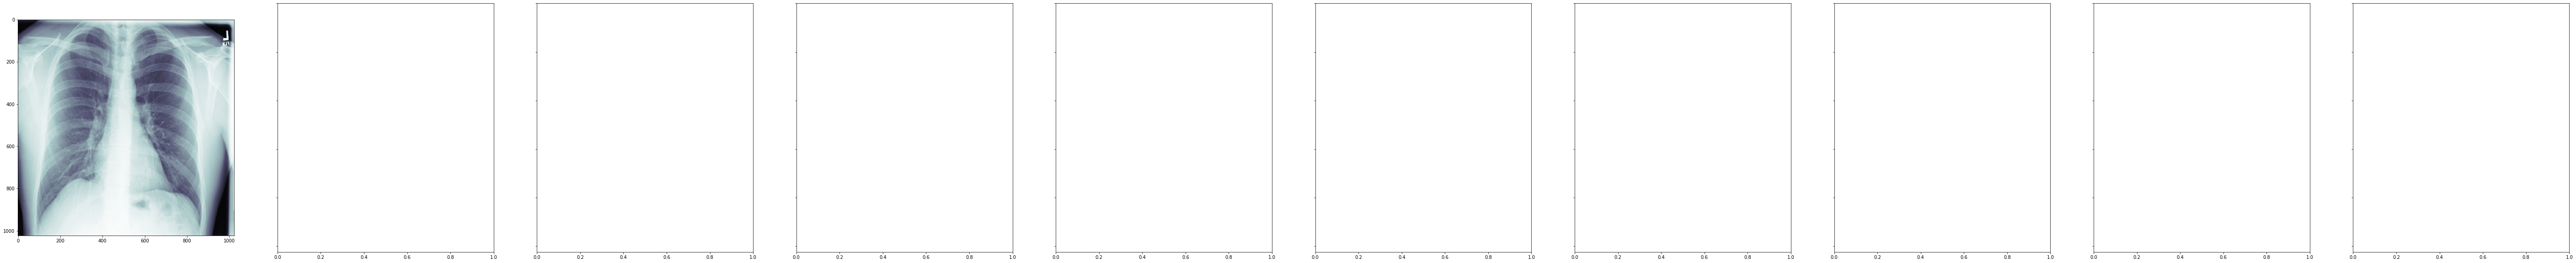

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = numberOfImages, sharey=True, figsize=(numberOfImages*10, 10))
for q, file in enumerate(glob(DATASET_PATH)[start:start+numberOfImages]):
    dataset = pydicom.dcmread(file)
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if RLEs.loc[file.split('\\')[-1][:-4],1] != '-1':
        mask = rle2mask(RLEs.loc[file.split('\\')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.7, cmap='Greens')
    else:
        ax[q].set_title('Nothing to see')